# Introduction to PerMaViss

This notebook introduces some of the objects and terminology used in PerMaViss. It explains in detail the used data structures, as well as the algorithmic intricacies of the persistence mayer vietoris algorithm.

© Copyright 2021, Álvaro Torras Casas, part of PerMaViss project.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(10)


In [2]:
mpl.font_manager.FontManager(size=20)

# 1. Basic Persistent Homology using PerMaViss

### 1.1. Generating a Random Circle

We start by importing the necessary modules

In [3]:
import permaviss

from permaviss.sample_point_clouds.examples import random_circle, take_sample

We sample 100 points around a noisy circle of radius 1. Then we take a subsample of 20 points by using the min-max algorithm.

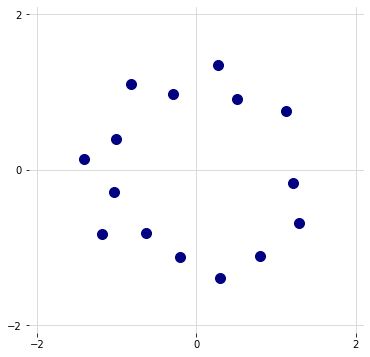

In [4]:
X = random_circle(100, 1, 0.5, seed=10)    # random points around a circle of radius 1
X = take_sample(X, 15, seed=4)   # subsample by using the min-max algorithm

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
ax.set(frame_on=False)
ax.grid(c='lightgray')
ax.scatter(X[:,0], X[:,1], s=100, c='navy')
ax.set_xlim([-2.1,2.1])
ax.set_ylim([-2.1,2.1])
plt.xticks([-2,0,2])
plt.yticks([-2,0,2])
plt.savefig("figures/sample_circle.png", pad_inches=0.05, bbox_inches=None)

### 1.2. Computing the Vietoris-Rips complex

First, we import the modules implementing the construction of filtered complexes. We also import a scipy submodule for computing the distance matrices.

In [5]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips

import scipy.spatial.distance as dist

Dist_X = dist.squareform(dist.pdist(X))

Then we proceed to compute the Vietoris-Rips complex on top of $X$, we set the maximum filtration radius at value 4 and the maximum dimension at value 3. Notice that in the following example $C$ is a list of lists whose first entry indicates the number of vertices, the filtration values are stored on a separated list of lists $R$; both $C$ and $R$ share the same indexing system: [dimension][simplex index]. Simplices in $C$ are stored by the collection of vertices: $[v_1, v_2 ..., v_n]$.

In [6]:
max_r = 4
max_dim = 3
C, R = vietoris_rips(Dist_X, max_r, max_dim)
print("Number of vertices: " + str(C[0]))
print("=======================")
for dim, C_dim in enumerate(C):
    if dim > 0:
        print("Dimension: " + str(dim))
        print("=======================")
        for spx_idx, simplex in enumerate(C_dim):
            print(str(C_dim[spx_idx]) + " --> " + "{:.3f}".format(R[dim][spx_idx]))
            if spx_idx > 5: # limit the display to 5 simplices per dimension
                print("...\n")
                break
            

Number of vertices: 15
Dimension: 1
[ 5 14] --> 0.484
[ 4 13] --> 0.499
[ 7 12] --> 0.518
[ 6 11] --> 0.531
[ 2 10] --> 0.547
[6 9] --> 0.560
[ 1 11] --> 0.561
...

Dimension: 2
[ 1  8 11] --> 0.665
[ 5  8 14] --> 0.685
[ 4 10 13] --> 0.801
[ 2 10 14] --> 0.919
[3 6 9] --> 1.000
[1 5 8] --> 1.002
[ 3  7 12] --> 1.026
...

Dimension: 3
[ 1  6  8 11] --> 1.185
[ 1  5  8 11] --> 1.236
[ 1  5  8 14] --> 1.248
[ 1  5 11 14] --> 1.269
[ 1  8 11 14] --> 1.269
[ 5  8 11 14] --> 1.269
[ 2  4 10 13] --> 1.343
...



### 1.3. Computing Classic Persistent Homology

In this section we compute persistent homology of $C$ by using the classic matrix approach with the twist implementation. 

In [7]:
import time
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

We compute the differentials of $C$ on the base field $Z$ mod $5$. Afterwards we compute persistent homology. Notice that the current implementation is slow.

In [8]:
p = 5 # perform computations on Z mod 5

start = time.time()
Diff = complex_differentials(C, p=5)
end = time.time()
print("Computing differentials took " + "{:.2f}".format(end - start) + " seconds.")
start = end
Hom, Im, PreIm = persistent_homology(Diff, R, max_r, p)
end = time.time()
print("Computing persistent homology took " + "{:.2f}".format(end - start) + " seconds.")

Computing differentials took 10.09 seconds.
Computing persistent homology took 43.88 seconds.


When computing persistent homology we recover $Hom$, $Im$ and $PreIm$, which store persistent homology classes, image representatives and preimages. These are lists indexed by dimension which contain information as barcode basis objects.

In [9]:
print("Hom length: " + str(len(Hom)) + "\n")
print("Hom[1] type: " + str(type(Hom[1])) + "\n")
print("Hom[1].barcode: \n" + str(Hom[1].barcode) + "\n")
print("Hom[1].coordinates.T: \n" + str(Hom[1].coordinates.T) + "\n")

print("Im length: " + str(len(Im)) + "\n")
print("Im[1] type: " + str(type(Im[1])) + "\n")
print("Im[1].barcode: \n" + str(Im[1].barcode[:3])[:-1] + "\n" + " ...\n" + " " + str(Im[1].barcode[-3:])[1:-1] + "]" + "\n") # limit output
print("Im[1].coordinates.T: \n" + str(Im[1].coordinates.T) + "\n")

print("PreIm length: " + str(len(PreIm)) + "\n")
print("PreIm[1] type: " + str(type(PreIm[1])) + "\n")
print("PreIm[1]: \n" + str(PreIm[1]) + "\n") 

Hom length: 4

Hom[1] type: <class 'permaviss.persistence_algebra.barcode_bases.barcode_basis'>

Hom[1].barcode: 
[[0.93966454 1.94179243]]

Hom[1].coordinates.T: 
[[0. 4. 4. 4. 0. 1. 0. 0. 0. 4. 1. 1. 1. 1. 4. 0. 0. 1. 4. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Im length: 4

Im[1] type: <class 'permaviss.persistence_algebra.barcode_bases.barcode_basis'>

Im[1].barcode: 
[[0.6648009  4.        ]
 [0.68466353 4.        ]
 [0.80052124 4.        ]
 ...
 [2.77053568 4.        ]
 [2.80922942 4.        ]
 [2.83070175 4.        ]]

Im[1].coordinates.T: 
[[0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 4. 0. 1.]]

PreIm length: 4

PreIm[1] type: <class 'numpy.ndarray'>

PreI

We may plot the obtained persistence diagram and representatives by using the information contained in $Hom$.

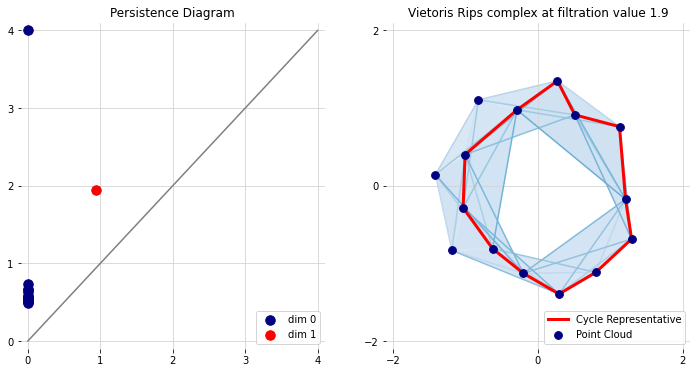

In [10]:
blues = mpl.cm.get_cmap('Blues') # get colormap for plotting
max_plotting_r = 1.9 # set maximum filtration for plotting purposes

fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

# plot point persistence diagram #################################################

ax0.set(frame_on=False)
ax0.grid(c='lightgray')

barcode0 = Hom[0].barcode
ax0.scatter(barcode0[:,0], barcode0[:,1], c='navy', s=90, label='dim 0', zorder=3)

barcode1 = Hom[1].barcode
ax0.scatter(barcode1[:,0], barcode1[:,1], c='red', s=90, label='dim 1', zorder=3)

ax0.plot([0, max_r], [0, max_r], c='gray') # plot diagonal 

# set axes layout
ax0.set_xlim([-0.1, max_r + 0.1])
ax0.set_ylim([-0.1, max_r + 0.1])
ax0.set_xticks(range(5))
ax0.set_yticks(range(5))
#set labels 
ax0.set_title("Persistence Diagram")
# avoid repeating labels on legend 
handles, labels = ax0.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax0.legend(by_label.values(), by_label.keys(), loc='lower right')

# plot cycle representative #################################################

ax1.set(frame_on=False)
ax1.grid(c='lightgray')

# plot 2D simplices
for idx, triangle in enumerate(C[2]):
    if R[2][idx] < max_plotting_r:
        vertices = X[triangle]
        ax1.fill(vertices[:, 0], vertices[:, 1], facecolor=blues(R[2][idx]/(5*max_plotting_r)))
# plot edges 
for idx, edge in enumerate(C[1]):
    if R[1][idx] < max_plotting_r:
        vertices = X[edge]
        ax1.plot(vertices[:, 0], vertices[:, 1], color=blues(R[1][idx]/(2*max_plotting_r)))

# add cycle representative
for idx, coeff in enumerate(Hom[1].coordinates[:, 0]):
    if coeff != 0:
        edge = C[1][idx] # get edge from index
        vertices = X[edge] # recover vertices
        ax1.plot(vertices[:, 0], vertices[:, 1], color='red', linewidth=3, label='Cycle Representative')
        
# scatter plot 
ax1.scatter(X[:,0], X[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

# set axes layout
ax1.set_xlim([-2.1,2.1])
ax1.set_ylim([-2.1,2.1])
ax1.set_xticks([-2,0,2])
ax1.set_yticks([-2,0,2])
#set labels 
ax1.set_title("Vietoris Rips complex at filtration value " + str(max_plotting_r))
# avoid repeating labels on legend 
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax1.legend(by_label.values(), by_label.keys(), loc='lower right')

# save figure ########################################################

plt.savefig("figures/diagram_rep_circle.png", pad_inches=0.05, bbox_inches=None)

In [11]:
np.max(np.array([[1,2],[3,4],[-1,-5]]))

4

# 2. Persistence Algebra

### 2.1. Barcode Bases

Barcode bases store bases associated to persistence modules. We always assume that intervals associated with generators are right-open. Let us start by creating a barcode basis object whose associated barcode contains the bars $[0,2)$, $[0,1)$, $[2,3)$ and $[2,2)$. 

In [12]:
from permaviss.persistence_algebra.barcode_bases import barcode_basis

bars = np.array([[1,2],[1,4],[0,3],[2,2]])
base1 = barcode_basis(bars)
print("Created base1\n")
print("Dimension of base1: " + str(base1.dim) + "\n")
print(base1)

Created base1

Dimension of base1: 3

Barcode basis
[[1 2]
 [1 4]
 [0 3]]



Notice that the trivial interval $[2,2)$ has been authomatically deleted. We can use the <code>barcode_basis.sort()</code> method to sort the intervals according to the standard interval order.

In [13]:
base1.sort()
print(base1)

Barcode basis
[[0 3]
 [1 4]
 [1 2]]



We can recover the persistence values at which some change happens at <code>base1</code> barcodes by using 
the method <code>barcode_basis.changes_list()</code>. Then, we might use the methods 
<code>barcode_basis.birth()</code> and <code>barcode_basis.death()</code> to know the indices of the generators 
which are being born or dying.

In [14]:
change_values = base1.changes_list()
print("Change value list: " + str(change_values) + "\n")
for x in change_values:
    print("Filtration Value: " + str(x))
    print("Generators being born: " + str(base1.birth(x)))
    print("Generators dying: " + str(base1.death(x)) + "\n")

Change value list: [0 1 2 3 4]

Filtration Value: 0
Generators being born: [0]
Generators dying: []

Filtration Value: 1
Generators being born: [1 2]
Generators dying: []

Filtration Value: 2
Generators being born: []
Generators dying: [2]

Filtration Value: 3
Generators being born: []
Generators dying: [0]

Filtration Value: 4
Generators being born: []
Generators dying: [1]



We might create a barcode basis object by referencing a previously created barcode basis object. This introduces coordinates. In the following example we create a new base referencing the previously created <code>base1</code>. Notice that when printing the created base two arrays are displayed: the associated barcode as well as the corresponding coordinates.

In [15]:
barcode =[[1,3], [2,4]]
coordinates = np.array([[1,0,-1], [1, 1, 0]]).T
base2 = barcode_basis(barcode, prev_basis=base1, coordinates=coordinates)
print(str(base2) + "\n")
print("We might also read this by using object attributes:")
print("base2.barcode:\n" + str(base2.barcode))
print("base2.coordinates:\n" + str(base2.coordinates))

Barcode basis
[[1 3]
 [2 4]]
[[ 1  1]
 [ 0  1]
 [-1  0]]


We might also read this by using object attributes:
base2.barcode:
[[1 3]
 [2 4]]
base2.coordinates:
[[ 1  1]
 [ 0  1]
 [-1  0]]


**Remark:** Although one might use coordinates to refer to a submodule base, this does not need to be the case. Often we will rather refer to the base of a quotient $N/K$ from a given sequence $K \subseteq N \subseteq M$, where the given previous basis will be that of $M$. This is important because the choice of coordinates is always limited by the setup, currently <code>PerMaViss</code> **does not check** whether the given coordinates are valid in this sense; so one needs to be careful when using the functions in persistence algebra directly.

### 2.2. The ImageKernel algorithm

We will now consider a pair of persistence modules $M$ and $N$ together with a persistence morphism $f:M\rightarrow N$.

In [62]:
from permaviss.persistence_algebra.image_kernel import image_kernel

base_M = barcode_basis([[0, 4], [0, 2], [1, 4], [1, 3]])
base_N = barcode_basis([[0, 3], [0, 2], [0, 2]])
F = np.array([[0, 0, 0, 1], [4, 0, 1, 3], [1, 0, 1, 4]])
Im, Ker, PreIm = image_kernel(base_M, base_N, F, p=5)

print("Im:")
print(str(Im) + "\n")
print("Ker:")
print(str(Ker) + "\n")
print("PreIm:")
print(str(PreIm) + "\n")

Im:
Barcode basis
[[0. 2.]
 [1. 3.]
 [1. 2.]]
[[0 1 0]
 [4 0 2]
 [1 0 0]]


Ker:
Barcode basis
[[0. 2.]
 [2. 4.]
 [2. 4.]]
[[0. 1. 4.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


PreIm:
[[1. 2. 4.]
 [0. 0. 0.]
 [0. 4. 1.]
 [0. 1. 0.]]



Let us plot some of this information so that it makes more sense:

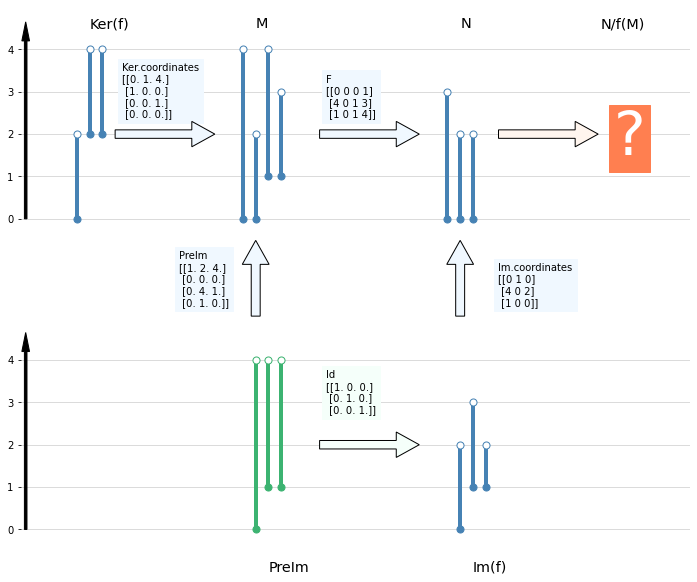

In [63]:
def plot_barcodes(barcode, x_pos, ax, color):
    for bar in barcode:
        ax.plot([x_pos, x_pos], [bar[0], bar[1]], linewidth=4, c=color, zorder=2.5)
        ax.scatter([x_pos], [bar[0]], s=50, c=color, zorder=3)
        ax.scatter([x_pos], [bar[1]], s=50, facecolors='white', edgecolors=color, zorder=3)
        x_pos+=0.5
    return x_pos

fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[3,1,3], hspace=0)

ax0 = fig.add_subplot(gs[0,0])
axm = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[2,0])

# plot sequence ker(f) -->  M  --> N --> N/f(M) ##############################################################
ax0.set(frame_on=False)
ax0.grid(c='lightgray')
ax0.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax0.set_xticks([])
ax0.set_yticks(range(5))
ax0.set_xlim([-0.2,26])
ax0.set_ylim([-0.5,5])
# plot ker(f)
x_pos = 2
ax0.text(x_pos+0.5, 4.5, "Ker(f)", fontsize='x-large')
x_pos = plot_barcodes(Ker.barcode, x_pos, ax0, 'steelblue')
ax0.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
ax0.text(x_pos+0.25, 2.4, "Ker.coordinates\n" + str(Ker.coordinates), backgroundcolor='aliceblue', zorder=2)
# plot M
x_pos+=5
ax0.text(x_pos+0.5, 4.5, "M", fontsize='x-large')
x_pos = plot_barcodes(base_M.barcode, x_pos, ax0, 'steelblue')
x_pos+=1
ax0.text(x_pos+0.25, 2.4, "F\n" + str(F), backgroundcolor='aliceblue', zorder=2)
ax0.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax0.text(x_pos+0.5, 4.5, "N", fontsize='x-large')
x_pos = plot_barcodes(base_N.barcode, x_pos, ax0, 'steelblue')
ax0.arrow(x_pos+0.5, 2, 3, 0, width=0.2, zorder=2.5, facecolor='seashell')
# plot N/f(M)
x_pos+=4
ax0.text(x_pos+0.5, 4.5, "N/f(M)", fontsize='x-large')
ax0.text(x_pos+1, 1.5, "?", fontsize=60, backgroundcolor='coral', color='white')

# plot middle 
axm.set(frame_on=False)
axm.set_xticks([])
axm.set_yticks([])
axm.set_xlim([-0.2,26])
axm.set_ylim([-0.1, 5])
x_pos=9
axm.text(x_pos-3, 0.7, "PreIm\n" + str(PreIm), backgroundcolor='aliceblue')
axm.arrow(x_pos, 0, 0, 3.4, width=0.35, zorder=3, facecolor='aliceblue')
x_pos+=8
axm.text(x_pos+1.5, 0.7, "Im.coordinates\n" + str(Im.coordinates), backgroundcolor='aliceblue')
axm.arrow(x_pos, 0, 0, 3.4, width=0.35, zorder=3, facecolor='aliceblue')

# plot sequence Im(f) --> N <--> N* <-- Coker(f) #####################################################
ax1.set(frame_on=False)
ax1.grid(c='lightgray')
ax1.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax1.set_xticks([])
ax1.set_yticks(range(5))
ax1.set_xlim([-0.2,26])
ax1.set_ylim([-0.5,5])
# plot Im(f)
x_pos=9
preim_barcode = np.array([[0,4],[1,4],[1,4]])
ax1.text(x_pos+0.5, -1, "PreIm", fontsize='x-large')
x_pos = plot_barcodes(preim_barcode, x_pos, ax1, 'mediumseagreen')
x_pos+=1
ax1.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='mintcream')
ax1.text(x_pos+0.25, 2.75, "Id\n" + str(np.identity(3)), backgroundcolor='mintcream', zorder=2.5)
# plot N
x_pos+=5.5
ax1.text(x_pos+0.5, -1, "Im(f)", fontsize='x-large')
x_pos = plot_barcodes(Im.barcode, x_pos, ax1, 'steelblue')

plt.savefig("figures/image_kernel_info.png", pad_inches=0.05, bbox_inches=None)

ImageKernel can be used to compute quotients. In this case, we use it for obtaining the missing cokernel.

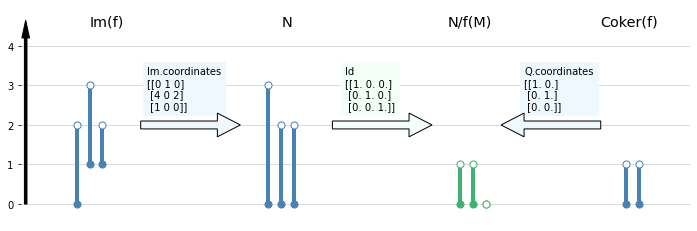

In [64]:
barcode_M_N = np.concatenate([base_M.barcode, base_N.barcode], axis=0)
base_M_N = barcode_basis(barcode_M_N)
F_Id = np.concatenate([F, np.identity(base_N.dim)], axis=1)

Q, _, = image_kernel(base_M_N, base_N, F_Id, p=5, start_index=4)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)

# plot sequence Im(f) -->  N  --> N/f(M) <-- Coker(f) ##############################################################
ax.set(frame_on=False)
ax.grid(c='lightgray')
ax.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax.set_xticks([])
ax.set_yticks(range(5))
ax.set_xlim([-0.2,26])
ax.set_ylim([-0.5,5])
# plot ker(f)
x_pos = 2
ax.text(x_pos+0.5, 4.5, "Im(f)", fontsize='x-large')
x_pos = plot_barcodes(Im.barcode, x_pos, ax, 'steelblue')
x_pos+=1
ax.text(x_pos+0.25, 2.4, "Im.coordinates\n" + str(Im.coordinates), backgroundcolor='aliceblue', zorder=2)
ax.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax.text(x_pos+0.5, 4.5, "N", fontsize='x-large')
x_pos = plot_barcodes(base_N.barcode, x_pos, ax, 'steelblue')
ax.text(x_pos+1.5, 2.4, "Id\n" + str(np.identity(3)), backgroundcolor='mintcream', zorder=2.5)
ax.arrow(x_pos+1, 2, 3, 0, width=0.2, zorder=2.5, facecolor='mintcream')
# plot N/f(M)
x_pos+=6
quotient_barcode = np.array([[0,1],[0,1],[0,0]])
ax.text(x_pos-0.5, 4.5, "N/f(M)", fontsize='x-large')
x_pos = plot_barcodes(quotient_barcode, x_pos, ax, 'mediumseagreen')# plot N/f(M)
ax.text(x_pos+1, 2.4, "Q.coordinates\n" + str(Q.coordinates), backgroundcolor='aliceblue', zorder=2)
ax.arrow(x_pos+4, 2, -3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot Coker(f)
x_pos+=5
ax.text(x_pos-1, 4.5, "Coker(f)", fontsize='x-large')
x_pos = plot_barcodes(Q.barcode, x_pos, ax, 'steelblue')

plt.savefig("figures/cokernel.png", pad_inches=0.05, bbox_inches=None)

### 2.3. Persistence Module Homology

Now we use image-kernel to compute homology of a persistence chain.

In [49]:
from permaviss.persistence_algebra.module_persistence_homology import module_persistence_homology

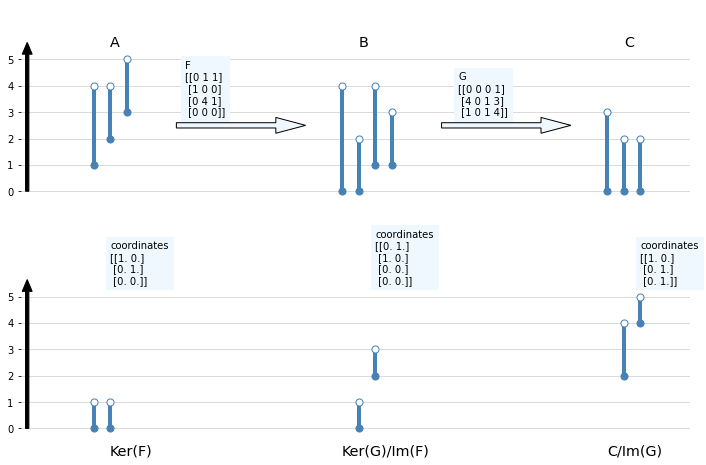

In [77]:
A = barcode_basis([[1, 4], [2, 4], [3, 5]])
B = barcode_basis([[0, 4], [0, 2], [1, 4], [1, 3]])
C = barcode_basis([[0, 3], [0, 2], [0, 2]])
Base = [Cpm,Bpm,Apm]
F = np.array([[0, 1, 1], [1, 0, 0], [0, 4, 1], [0, 0, 0]])
G = np.array([[0, 0, 0, 1], [4, 0, 1, 3], [1, 0, 1, 4]])
D = [0, G, F]
Hom, Im, PreIm = module_persistence_homology(D, Base, 5)

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

# plot sequence A --> B --> C ##############################################################
ax0.set(frame_on=False)
ax0.grid(c='lightgray')
ax0.arrow(0, 0, 0, 5.2, width=0.1, color='black', zorder=2.5)
ax0.set_xticks([])
ax0.set_yticks(range(6))
ax0.set_xlim([-0.2,20])
ax0.set_ylim([-0.5,7])
# plot ker(f)
x_pos = 2
ax0.text(x_pos+0.5, 5.5, "A", fontsize='x-large')
x_pos = plot_barcodes(A.barcode, x_pos, ax0, 'steelblue')
x_pos+=1
ax0.text(x_pos+0.25, 2.9, "F\n" + str(F), backgroundcolor='aliceblue', zorder=2)
ax0.arrow(x_pos, 2.5, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax0.text(x_pos+0.5, 5.5, "B", fontsize='x-large')
x_pos = plot_barcodes(B.barcode, x_pos, ax0, 'steelblue')
ax0.text(x_pos+1.5, 2.9, "G\n" + str(G), backgroundcolor='aliceblue', zorder=2.5)
ax0.arrow(x_pos+1, 2.5, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N/f(M)
x_pos+=6
ax0.text(x_pos+0.5, 5.5, "C", fontsize='x-large')
x_pos = plot_barcodes(C.barcode, x_pos, ax0, 'steelblue')# plot N/f(M)

# plot sequence Ker(F) --> Ker(G)/Im(F) --> C/Im(G) ##############################################################
ax1.set(frame_on=False)
ax1.grid(c='lightgray')
ax1.arrow(0, 0, 0, 5.2, width=0.1, color='black', zorder=2.5)
ax1.set_xticks([])
ax1.set_yticks(range(6))
ax1.set_xlim([-0.2,20])
ax1.set_ylim([-0.5,7])
# plot ker(f)
x_pos = 2
ax1.text(x_pos+0.5, -1, "Ker(F)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[0].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[0].barcode, x_pos, ax1, 'steelblue')
x_pos+=1
# plot N
x_pos+=6
ax1.text(x_pos-0.5, -1, "Ker(G)/Im(F)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[1].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[1].barcode, x_pos, ax1, 'steelblue')
# plot N/f(M)
x_pos+=7
ax1.text(x_pos-0.5, -1, "C/Im(G)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[2].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[2].barcode, x_pos, ax1, 'steelblue')# plot N/f(M)

plt.savefig("figures/persistence_module_homology.png", pad_inches=0.05, bbox_inches=None)

# 3. Čech Homology

### 3.1. Dividing Pointclouds into Cubical Regions

### 3.2. Computing Local Persistent Homology in parallel

### 3.3. Local Chains Class

### 3.4. Čech differentials and Čech Homology

### 3.5. Illustration of some examples

# 4. Computing the spectral sequence

### 4.1. Total Complex Representatives

### 4.2. Computing Higher Pages

### 4.3. Extension Problem

# 5. A brief example Using PerMaViss
### 5.1. Computing the spectral sequence

### 5.2. Plotting the Results

# 6. Conclusion

There are still a few functions to include in PerMaViss...

I hope you enjoyed the tutorial! 